In [1]:
#Visualize the resulting average system delay in function of the arrival rate (notebook version)
import numpy as np
from math import log,exp
import subprocess
import matplotlib.pyplot as plt
import itertools as it
import configparser

In [2]:
#Constants
TRANSMISSION_RATE_A = 30000000 #(in bits/s)
TRANSMISSION_RATE_B = 20000000
TRANSMISSION_RATE_C = 10000000

MIN_PKT_SIZE = 64 * 8 
AVG_PKT_SIZE = 782 * 8 #(in bits)
MAX_PKT_SIZE = 1500 * 8

Q_LIMIT = 1000
N = 10000
SEEDS = [1,2,3,4,5]

#Simulator inputs
SERVICE_TIME_B = AVG_PKT_SIZE / TRANSMISSION_RATE_B
SERVICE_TIME_C = AVG_PKT_SIZE / TRANSMISSION_RATE_C

#NOTE: 1500 is a little less than 1/SERVICE_TIME_C
INTERARRIVAL_TIMES = [1/x for x in range(10, 1500, 25)] #valid values: 830, 1500   #[1/x for x in range(1000, 4001, 100)] #expon: [1/x for x in range(10, 830, 25)]

#INTERARRIVAL_TIMES = np.linspace(1/10, 1/1830, 50)
#INTERARRIVAL_TIMES = INTERARRIVAL_TIMES[34:-1] #remove first and last

In [3]:
#theorical system delay
def system_delay_th(mean):
    lambd = 1/mean
    util1 = lambd / (1/SERVICE_TIME_B) #mu1
    util2 = lambd / (1/SERVICE_TIME_C) #mu2
    
    
    return (util1 / (lambd * (1 - util1))) + (util2 / (lambd * (1 - util2)))

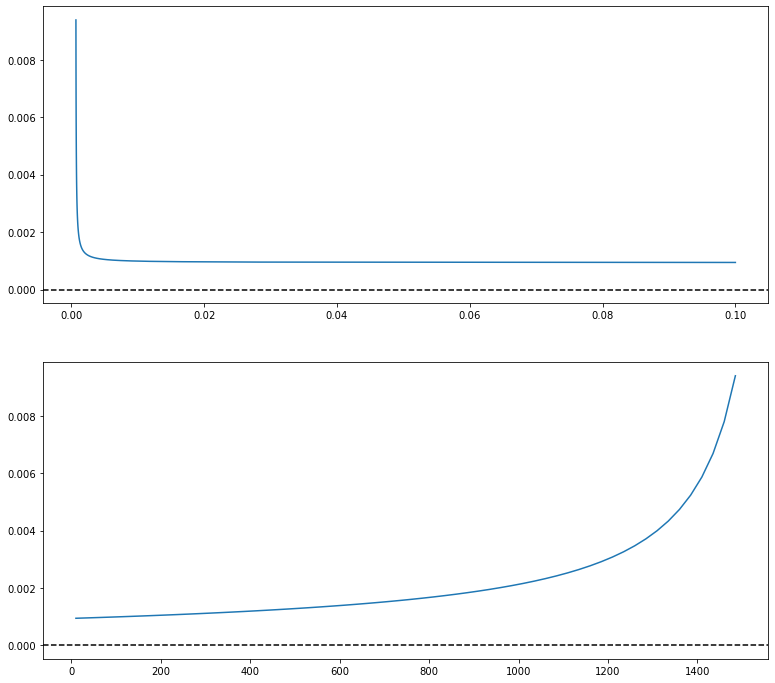

In [4]:
fig, axs = plt.subplots(figsize=(13, 12), nrows=2)

x = []
y = []
for interarrival_time in INTERARRIVAL_TIMES:
    with np.errstate(divide='raise'):
        try:
            val = system_delay_th(interarrival_time)
            
            x.append(interarrival_time)
            y.append(val)
        except FloatingPointError:
            print(f"skipped {interarrival_time} due to overflow")

axs[0].plot(x, y)
axs[1].plot([1/i for i in x], y)
for i in range(0, len(axs)):
    axs[i].axhline(0, linestyle="--", color="black")

seed:  1
x:  [10.0, 35.0, 60.0, 85.0, 110.0, 135.0, 160.0, 185.0, 209.99999999999997, 235.0, 260.0, 285.0, 310.0, 335.0, 360.0, 385.0, 410.0, 435.0, 460.0, 485.0, 510.0, 535.0, 560.0, 585.0, 610.0, 635.0, 660.0, 685.0, 710.0, 735.0, 760.0, 785.0, 810.0, 835.0, 860.0, 885.0, 910.0, 935.0, 960.0, 985.0, 1010.0, 1035.0, 1060.0, 1085.0, 1110.0, 1135.0, 1160.0, 1185.0, 1210.0, 1235.0, 1260.0, 1285.0, 1310.0, 1335.0, 1360.0, 1385.0, 1410.0, 1435.0, 1460.0, 1485.0]
y:  [0.00094165, 0.000952677, 0.000965411, 0.000976795, 0.000992768, 0.00100542, 0.00101645, 0.00103142, 0.00104596, 0.00106466, 0.00107723, 0.00109107, 0.00110671, 0.00112756, 0.00115264, 0.00116543, 0.00117461, 0.0011895, 0.00122523, 0.00124194, 0.00125046, 0.00128182, 0.00131549, 0.00134237, 0.00138318, 0.00139572, 0.00143982, 0.00148316, 0.00154986, 0.00157472, 0.00159146, 0.00162386, 0.00170236, 0.0017039, 0.00176364, 0.00181105, 0.00186801, 0.00182516, 0.00197866, 0.00195299, 0.00211863, 0.00212502, 0.00228742, 0.00243584, 0.

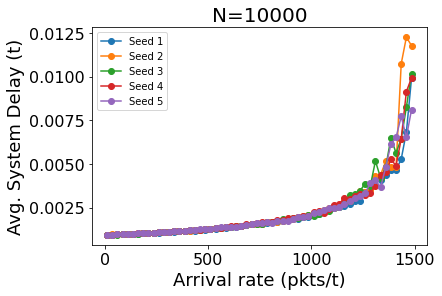

In [99]:
#Prepare plot
fig, ax = plt.subplots()
ax.set_xlabel("Arrival rate (pkts/t)", fontsize=18)
ax.set_ylabel(f"Avg. System Delay (t)", fontsize=18)
ax.set_title(f"N={N}", fontsize=20)
ax.tick_params(axis='x', which='both', labelsize=16)
ax.tick_params(axis='y', which='both', labelsize=16)    
ax.ticklabel_format(useOffset=False)

#Read config file
config = configparser.ConfigParser()
config.optionxform = str #to preserve case
config.read("input.txt")

#Fixed parameters
config.set('SYSTEM', 'mean_service_time_1', '{:f}'.format(SERVICE_TIME_B))
config.set('SYSTEM', 'mean_service_time_2', '{:f}'.format(SERVICE_TIME_C))
config.set('SYSTEM', 'min_pkt_size', '{:f}'.format(MIN_PKT_SIZE))
config.set('SYSTEM', 'avg_pkt_size', '{:f}'.format(AVG_PKT_SIZE))
config.set('SYSTEM', 'max_pkt_size', '{:f}'.format(MAX_PKT_SIZE))
config.set('SYSTEM', "q_limit", str(Q_LIMIT))
config.set('SYSTEM', 'num_pkts', str(N))


#experimental
for seed in SEEDS:
    print("seed: ", seed)
    system_delays = []
    
    x = list(map(lambda x:1/x, INTERARRIVAL_TIMES)) #1/x because we plot in function of the arrival rate
    
    for interarrival_time in INTERARRIVAL_TIMES:
        #Modify config file with given parameters
        config.set('SYSTEM', 'mean_interarrival_time', str(interarrival_time))
        config.set('SYSTEM', 'seed', str(seed))

        with open("input.txt", "w") as f:
            config.write(f, space_around_delimiters=False) #important to avoid breaking my c++ parser

        #run simulation (suppressing output)
        try:
            subprocess.check_call(["./main"], stdout=subprocess.DEVNULL)
        except subprocess.CalledProcessError:
            print("\nconfig that caused error: ")
            for key in config['SYSTEM']:
                print(key, config['SYSTEM'][key])

        #Retrieve avg. system delay
        try:
            with open("output.txt", "r") as f:
                sd_line = f.read()
                system_delays.append(float(sd_line.rstrip()))
        except OSError as e:
            print(e.errno)
            raise SystemExit("STOP")
    
    #Plot
    ax.plot(x, system_delays, label=f"Seed {seed}", marker="o")
    ax.legend()
    
    print("x: ", x)
    print("y: ", system_delays)
    print("")

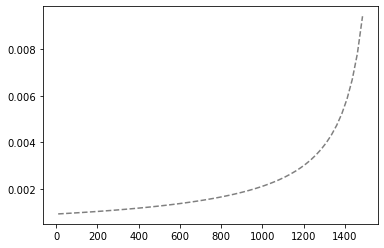

In [100]:
#theorical
th_system_delays = []  
for interarrival_time in INTERARRIVAL_TIMES:
    th_system_delays.append(system_delay_th(interarrival_time))
plt.plot(x, th_system_delays, label="Theorical", linestyle="--", color="grey")
plt.show()